# Simulación de Ecuaciones de Agua Poco Profunda en 1D

## Solución Numérica usando el Método de Elementos Finitos

## Paquetes Utilizados

En este proyecto, utilizaremos varios paquetes de Python que nos ayudarán a realizar diferentes tareas de manera eficiente. A continuación, se describen los paquetes que se utilizarán:

1. **NumPy**:
   - **Descripción**: NumPy es una biblioteca fundamental para la computación científica en Python. Proporciona soporte para arrays y matrices multidimensionales, junto con una colección de funciones matemáticas para operar con estos arrays de manera eficiente.
   - **Uso**: En este proyecto, utilizaremos NumPy para realizar cálculos numéricos y manipulación de datos.

   ```python
   import numpy as np

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time

import basis
import evolve 
import integrator
import test

### Input Parameters

Input parameters are crucial in programming and data analysis for several reasons:

1. **Flexibility**: They allow functions and programs to be more flexible and reusable. By passing different input parameters, the same function can perform a variety of tasks without modification.

2. **Modularity**: Input parameters help in breaking down complex problems into smaller, manageable pieces. Each function can focus on a specific task, making the code easier to understand and maintain.

3. **Scalability**: They enable the handling of different data sets or conditions without changing the core logic of the program. This is particularly important in data analysis, where the same analysis might need to be applied to different data sets.

4. **Testing and Debugging**: With input parameters, it is easier to test and debug functions. You can pass different values to the function to see how it behaves, which helps in identifying and fixing issues.

5. **Interoperability**: In collaborative environments, input parameters allow different parts of a system to interact seamlessly. Different modules or components can call functions with the required parameters, ensuring smooth integration.

Overall, input parameters are a fundamental concept that enhances the functionality, efficiency, and maintainability of code.

In [64]:
# input parameters

# Physical domain 
x_initial = 0 # (m) initial domain coordinate
x_final = 10 # (m) final domain coordinate

# DG method
N_elements= 10 # number of elements
p_basis_order = 1 # lagrange basis order

# simulation time
n_steps = 200 # number of time steps
t_limit = 1 # (s) simulation time limit

# Gauss cuadrature
n_gauss_poins = 20 

# plotting setting
plot_every_steps = 200

# PDE evolution method # 0: euler, 1: rk4
evolution_method = 1

## Generacion de cuadricula de elementos

La generación de una malla y una cuadrícula es fundamental en el método de elementos finitos, especialmente en el método de Galerkin discontinuo (DG), por varias razones:

1. **Discretización del dominio**: La malla divide el dominio continuo en elementos finitos más pequeños, lo que permite aproximar la solución de la ecuación diferencial en cada uno de estos elementos. En el método DG, cada elemento puede tener su propia solución polinómica, lo que permite capturar discontinuidades y variaciones abruptas en la solución.

2. **Flexibilidad en la representación**: La cuadrícula permite representar geometrías complejas y adaptarse a diferentes escalas de variación en la solución. Esto es especialmente útil en problemas donde la solución tiene características locales que requieren una mayor resolución.

3. **Precisión y convergencia**: Una malla bien diseñada puede mejorar la precisión de la solución y la tasa de convergencia del método numérico. En el método DG, la elección de la malla y el orden de los polinomios en cada elemento son cruciales para obtener resultados precisos.

4. **Implementación de condiciones de contorno**: La malla facilita la implementación de condiciones de contorno, ya que permite definir claramente los límites del dominio y aplicar las condiciones adecuadas en los nodos correspondientes.

5. **Paralelización y eficiencia computacional**: La estructura de la malla permite dividir el problema en subproblemas más pequeños que pueden ser resueltos en paralelo, mejorando la eficiencia computacional. En el método DG, cada elemento puede ser tratado de manera independiente, lo que facilita la paralelización.

En resumen, la generación de una malla y una cuadrícula es un paso esencial en el método de elementos finitos, ya que permite discretizar el dominio, representar la solución con flexibilidad, mejorar la precisión y eficiencia computacional, y aplicar condiciones de contorno de manera efectiva.

In [72]:
def generate_1d_mesh(initial_coord, final_coord, num_elements, basis_order):
    """
    Genera una malla unidimensional (1D) en el dominio físico especificado.

    @param initial_coord: Coordenada inicial del dominio físico.
    @param final_coord: Coordenada final del dominio físico.
    @param num_elements: Número de elementos en la malla.
    @param basis_order: Orden de la base de Lagrange.

    @return: Coordenadas de los nodos en el espacio físico.
    """
    
    print(f'Generando malla \nDominio físico: [{initial_coord},{final_coord}] metros\nNúmero de elementos: {num_elements}\nNodos por elemento: {basis_order+1}\nOrden de la base de Lagrange: {basis_order}')

    # Generar coordenadas de los elementos
    elements_division = np.linspace(initial_coord, final_coord, num_elements + 1)

    # Calcular las coordenadas de los nodos en el espacio físico dentro de cada elemento
    if basis_order != 0:
        nodes_coord_phys_space = np.array([np.linspace(elements_division[i], elements_division[i + 1], basis_order + 1) for i in np.arange(num_elements)])
    else:
        nodes_coord_phys_space = np.array([[elements_division[i] + 0.5 * (elements_division[i+1] - elements_division[i])] for i in np.arange(num_elements)])

    return nodes_coord_phys_space

nodes_coordinates_phys_space = generate_1d_mesh(x_initial, x_final, N_elements, p_basis_order)


Generando malla 
Dominio físico: [0,10] metros
Número de elementos: 10
Nodos por elemento: 2
Orden de la base de Lagrange: 1


## Funciones Base de Lagrange

Las funciones base de Lagrange son polinomios utilizados en el método de elementos finitos para la interpolación de funciones. Estas funciones tienen varias propiedades importantes que las hacen útiles en la solución numérica de ecuaciones diferenciales parciales.

### Definición

Para un conjunto de nodos \( x_0, x_1, \ldots, x_n \), las funciones base de Lagrange \( L_i(x) \) se definen como:

\[ L_i(x) = \prod_{\substack{0 \le j \le n \\ j \ne i}} \frac{x - x_j}{x_i - x_j} \]

donde \( L_i(x) \) es un polinomio de grado \( n \) que toma el valor 1 en el nodo \( x_i \) y 0 en los otros nodos \( x_j \) para \( j \ne i \).

### Propiedades

1. **Interpolación Exacta**: Las funciones base de Lagrange interpolan exactamente los valores en los nodos dados. Es decir, \( L_i(x_j) = \delta_{ij} \), donde \( \delta_{ij} \) es el delta de Kronecker.

2. **Ortogonalidad**: Aunque no son ortogonales en el sentido clásico, las funciones base de Lagrange tienen la propiedad de ser mutuamente exclusivas en los nodos, lo que facilita la interpolación.

3. **Flexibilidad**: Pueden ser utilizadas para interpolar funciones en cualquier conjunto de nodos, no necesariamente equiespaciados.

### Uso en el Método de Elementos Finitos

En el método de elementos finitos, las funciones base de Lagrange se utilizan para aproximar la solución de una ecuación diferencial en cada elemento del dominio. La solución aproximada se expresa como una combinación lineal de las funciones base:

\[ u(x) \approx \sum_{i=0}^{n} u_i L_i(x) \]

donde \( u_i \) son los coeficientes que se determinan mediante la solución del sistema de ecuaciones resultante de la discretización del problema.

### Ejemplo

Para un elemento con dos nodos (\( n = 1 \)), las funciones base de Lagrange son:

\[ L_0(x) = \frac{x - x_1}{x_0 - x_1} \]
\[ L_1(x) = \frac{x - x_0}{x_1 - x_0} \]

Estas funciones se utilizan para interpolar una función \( u(x) \) en el intervalo \([x_0, x_1]\).

En resumen, las funciones base de Lagrange son una herramienta fundamental en la interpolación y aproximación de funciones en el método de elementos finitos, proporcionando una base flexible y eficiente para la solución numérica de ecuaciones diferenciales.

In [73]:
element_number = np.arange(N_elements)
element_lengths = nodes_coordinates_phys_space[:,-1] - nodes_coordinates_phys_space[:,0]

# generating reference space information
gauss_weights, basis_values_at_gauss_quad, basis_values_x_derivative_at_gauss_quad, basis_values_at_nodes = basis.generate_reference_space(nodes_coordinates_phys_space, n_gauss_poins)


## Condiciones initiales

La función `generate_initial_conditions` tiene como objetivo generar las condiciones iniciales de altura y velocidad en función de las coordenadas de los nodos de todos los elementos.

### Desglose de la función:

1. **Definición de la altura inicial:**
    ```python
    def initial_height(x):
        h = 1 + 0.1 * np.exp(-(x - 5) ** 2)
        return h
    ```
    Esta función interna `initial_height` calcula la altura inicial `h` en función de la coordenada `x`. Utiliza una fórmula que incluye una constante base de 1 y un término exponencial que depende de la distancia de `x` al valor 5.

2. **Definición de la velocidad inicial:**
    ```python
    def velocity_initial(x):
        u = 0
        return u
    ```
    Esta función interna `velocity_initial` asigna una velocidad inicial `u` de 0 para cualquier valor de `x`.

3. **Asignación de la altura y velocidad inicial en cada nodo de los elementos:**
    ```python
    h_height = [np.array([initial_height(x_n) for x_n in nodes_in_elem]) for nodes_in_elem in nodes_coords_all_elem]
    u_velocity = [np.array([velocity_initial(x_n) for x_n in nodes_in_elem]) for nodes_in_elem in nodes_coords_all_elem]
    ```
    Aquí se crean listas de arrays de NumPy que contienen las alturas y velocidades iniciales para cada nodo en cada elemento. Se utiliza una comprensión de listas para aplicar las funciones `initial_height` y `velocity_initial` a cada coordenada `x_n` en los nodos de cada elemento.

4. **Conversión a arrays de NumPy:**
    ```python
    h_height = np.array(h_height)
    u_velocity = np.array(u_velocity)
    ```
    Las listas de alturas y velocidades se convierten en arrays de NumPy para facilitar su manipulación y cálculo posterior.

5. **Retorno de las condiciones iniciales:**
    ```python
    return h_height, u_velocity
    ```
    La función retorna dos arrays: `h_height` con las alturas iniciales y `u_velocity` con las velocidades iniciales.

### Generación de las condiciones iniciales:
```python
h, u = generate_initial_conditions(nodes_coordinates_phys_space)

In [67]:
def generate_initial_conditions(nodes_coords_all_elem):

    # initial height as function of x
    def initial_height(x):
        h=1+0.1*np.exp(-(x-5)**2)
        return h

    # initial velocity as function of x
    def velocity_initial(x):
        u=0
        return u

    # Setting the initial height and velocity in each element node
    h_height = [np.array([initial_height(x_n) for x_n in nodes_in_elem]) for nodes_in_elem in nodes_coords_all_elem]
    u_velocity = [np.array([velocity_initial(x_n) for x_n in nodes_in_elem]) for nodes_in_elem in nodes_coords_all_elem]
    
    h_height = np.array(h_height)
    u_velocity = np.array(u_velocity)

    return h_height, u_velocity

# generating initial conditions
h, u = generate_initial_conditions(nodes_coordinates_phys_space)

In [68]:
# compute mass matrix M_ij = integral phi_i(x) phi_j(x) dx and return the inverse matrix of M_ij
mass_matrix_inverse = evolve.compute_mass_matrix_inverse(element_lengths, gauss_weights, basis_values_at_gauss_quad)


In [69]:
# time step
time_step = np.array(t_limit/n_steps) 

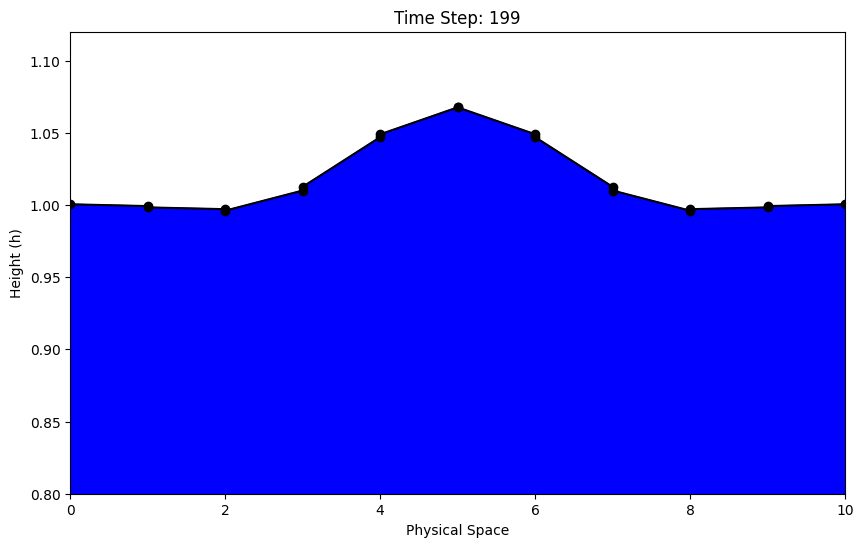

Done


In [76]:

# evolving in time the PDE
for number_of_t_step in np.arange(n_steps):

    # plotting

    clear_output(wait=True)  # Clear the output of the current cell    
    plt.figure(figsize=(10, 6))
    plt.clf()  # Clear the current figure
    for i in range(N_elements):
        plt.plot(nodes_coordinates_phys_space[i], h[i], color='black', linestyle='-', marker='o')
        plt.fill_between(nodes_coordinates_phys_space[i], h[i], 0, color='blue')
    plt.ylim(0.8, 1.12)
    plt.xlim(0.0, 10.0)
    # plt.gca().set_aspect('equal', adjustable='box')  
    plt.xlabel('Physical Space')
    plt.ylabel('Height (h)')
    plt.title(f'Time Step: {number_of_t_step}')
    # plt.legend()
    # plt.grid(True)
    plt.show()
    time.sleep(0)  # Pause for a second to see the change

    # saving the data
    # if (number_of_t_step+1) % plot_every_steps == 0 or number_of_t_step == 0:

        # print(f'Number of time step : {number_of_t_step+1} / {n_steps}')

        
    # If true using euler method
    if evolution_method==0:
        h, u = integrator.euler_method( h, u, time_step, element_number, basis_values_at_gauss_quad, basis_values_x_derivative_at_gauss_quad, gauss_weights, element_lengths, basis_values_at_nodes, mass_matrix_inverse)

    # If true using RK4 method
    if evolution_method==1:
        h, u = integrator.rk4_method( h, u, time_step, element_number, basis_values_at_gauss_quad, basis_values_x_derivative_at_gauss_quad, gauss_weights, element_lengths, basis_values_at_nodes, mass_matrix_inverse)

    # compute entropy : integral 0.5 * ( g * h**2 + h * u ) dx
    # entropy = evolve.compute_entropy(element_lengths, gauss_weights, basis_values_at_gauss_quad, h, u)

    # writing data
    # integrator.write_data_file(nodes_coordinates_phys_space,entropy,h,u,False,number_of_t_step+1, t_limit, n_steps)

print(f'Done')